In [2]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
import datetime
import os

% matplotlib inline

In [3]:
mp.rcParams.update({'mathtext.default': 'regular'})
#get_ipython().magic('matplotlib inline')

# ======================================================================

PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

# ======================================================================

#working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'

#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

threshold = 0.1

year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

year_start = 1920
year_end = 2100

lo_perc = 20
hi_perc = 80

#year_start_whiplash = 1920
#year_end_whiplash = 1950

year_start_list = numpy.arange(1920,2100)
#year_end_list = numpy.arange(1950,2101)

whiplash_ratios_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_pic_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_rcp_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))

# create list of names of members '001','002','003', ...
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'

# create season strings for PIC
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]
n_seasons_pic=year_end_pic-year_start_pic

# ========== open pic
ncfile = netCDF4.Dataset('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/create_ncfiles_seasonal/'+\
                       'seasonal_totals_pic.nc', 'r', 'NETCDF4')
seasonal_totals_pic = ncfile.variables['seasonal_total'][:]
seasonal_totals_pic = seasonal_totals_pic.reshape((1798,-1))

# ========== open hist+rcp
ncfile = netCDF4.Dataset('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/create_ncfiles_seasonal/'+\
                       'seasonal_totals_hist_rcp.nc', 'r', 'NETCDF4')
seasonal_totals_hist_rcp = ncfile.variables['seasonal_total'][:]
seasonal_totals_hist_rcp = seasonal_totals_hist_rcp.reshape((180,40,-1))

all_hist_rcp_markers = numpy.zeros((180,40,len(latlon_indices)), dtype=numpy.int)
all_pic_markers = numpy.zeros((1798,len(latlon_indices)), dtype=numpy.int)

In [4]:
for latlon_idx in range(len(latlon_indices)):

    #if latlon_idx%10==0:
    #    print('latlon_idx', latlon_idx)

    # ======================================================================
    # Open preindustrial control info (dict_pic)
    seasonal_total_pic = seasonal_totals_pic[:,latlon_idx]
    #print(seasonal_total_pic)
    
    # ======================================================================
    # ======================================================================
    # ======================================================================
    # whiplash calculation setup
    # get top and bottom 10th percentiles in PIC
    # then see how often it transitions from 1 or 2 seasons with that

    pic_hi = numpy.percentile(seasonal_total_pic, hi_perc)

    # take 3 year running mean for pic_lo
    seasonal_total_pic_window_mean = numpy.array(pandas.Series(seasonal_total_pic).rolling(window=window).mean())
    pic_lo = numpy.nanpercentile(seasonal_total_pic_window_mean, lo_perc)

    #print(seasonal_totals_hist_rcp.shape)
    #print(whiplash_hist_rcp_markers.shape)

    #for ens_idx in range(40):
    #    whiplash_hist_rcp_markers[:,:,latlon_idx][ seasonal_totals_hist_rcp[:,ens_idx,latlon_idx]<pic_lo ] = -1
    all_hist_rcp_markers[:,:,latlon_idx][ seasonal_totals_hist_rcp[:,:,latlon_idx]<pic_lo ] = -1
    all_hist_rcp_markers[:,:,latlon_idx][ seasonal_totals_hist_rcp[:,:,latlon_idx]>pic_hi ] = 1

# calculate percent change
# if the pic starts at 20th percentile across entire domain, then find the 20th percentile across all ensemble members
# same with 80th percentile

ratio_wet_dry = numpy.zeros((180, len(latlon_indices) ))
wet_total = numpy.zeros((180, len(latlon_indices) ))
dry_total = numpy.zeros((180, len(latlon_indices) ))

for latlon_idx in range(len(latlon_indices)):
    wet_total[:,latlon_idx] = numpy.sum(all_hist_rcp_markers[:,:,latlon_idx]==1, axis=1)
    dry_total[:,latlon_idx] = numpy.sum(all_hist_rcp_markers[:,:,latlon_idx]==-1, axis=1)

wet_total_fraction = wet_total/40.
dry_total_fraction = dry_total/40.

#wet_total_fraction = wet_total_fraction.reshape((180, PRECT_nlat, PRECT_nlon))
#dry_total_fraction = dry_total_fraction.reshape((180, PRECT_nlat, PRECT_nlon))

# Calculate dry and wet ratios (all events, whiplash or not)

In [5]:
all_hist_rcp_markers_reshape = all_hist_rcp_markers.reshape((180,40,26,25))
all_hist_rcp_dry = numpy.array((all_hist_rcp_markers_reshape==-1),dtype=numpy.int)
all_hist_rcp_wet = numpy.array((all_hist_rcp_markers_reshape==1),dtype=numpy.int)

all_hist_rcp_dry_40mean = numpy.mean(all_hist_rcp_dry, axis=1)
all_hist_rcp_wet_40mean = numpy.mean(all_hist_rcp_wet, axis=1)

all_hist_rcp_wet_to_dry_ratio = all_hist_rcp_wet_40mean/all_hist_rcp_dry_40mean

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


# Plot whiplash wet/dry

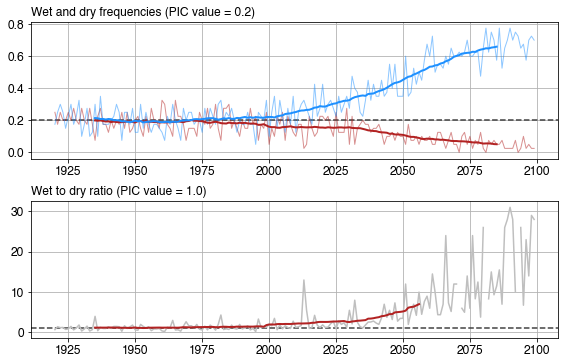

In [6]:
lat_idx = 17
lon_idx = 17

plot_this1 = all_hist_rcp_dry_40mean[:,lat_idx,lon_idx]
plot_this2 = all_hist_rcp_wet_40mean[:,lat_idx,lon_idx]
plot_this1_rolling = pandas.Series(plot_this1).rolling(window=30, center=True).mean()
plot_this2_rolling = pandas.Series(plot_this2).rolling(window=30, center=True).mean()

fontsize=12

fig,ax = mp.subplots(2,1)
fig.set_size_inches(8,5)

ax[0].axhline(y=0.2, c='0.25', ls='--')

ax[0].plot(numpy.arange(1920,2100), plot_this1, c='firebrick', lw=1, alpha=0.5)
ax[0].plot(numpy.arange(1920,2100), plot_this2, c='dodgerblue', lw=1, alpha=0.5)
ax[0].plot(numpy.arange(1920,2100), plot_this1_rolling, c='firebrick', lw=2)
ax[0].plot(numpy.arange(1920,2100), plot_this2_rolling, c='dodgerblue', lw=2)

ax[0].text(x=0,y=1.02,s='Wet and dry frequencies (PIC value = 0.2)', transform=ax[0].transAxes, fontsize=fontsize, ha='left', va='bottom')
ax[0].tick_params(labelsize=fontsize)
ax[0].grid()




plot_this = all_hist_rcp_wet_to_dry_ratio[:,lat_idx,lon_idx]
plot_this_rolling = pandas.Series(plot_this).rolling(window=30, center=True).mean()

ax[1].axhline(y=1, c='0.25', ls='--')

#ax.plot(numpy.arange(1920,2100), whiplash_hist_rcp_dry_40mean[:,9,17])
#ax.plot(numpy.arange(1920,2100), whiplash_hist_rcp_wet_40mean[:,9,17])
ax[1].plot(numpy.arange(1920,2100), plot_this, c='0.75')
ax[1].plot(numpy.arange(1920,2100), plot_this_rolling, c='firebrick', lw=2)

ax[1].text(x=0,y=1.02,s='Wet to dry ratio (PIC value = 1.0)', transform=ax[1].transAxes, fontsize=fontsize, ha='left', va='bottom')
ax[1].tick_params(labelsize=fontsize)
ax[1].grid()

fig.tight_layout(h_pad=2)

# Now calculate pure whiplash events for PIC and hist+RCP8.5

In [7]:
whiplash_hist_rcp_markers = numpy.zeros((180,40,len(latlon_indices)), dtype=numpy.int)
whiplash_pic_markers = numpy.zeros((1798,len(latlon_indices)), dtype=numpy.int)

for latlon_idx in range(len(latlon_indices)):

    #if latlon_idx%10==0:
    #    print('latlon_idx', latlon_idx)

    # ======================================================================
    # Open preindustrial control info (dict_pic)
    seasonal_total_pic = seasonal_totals_pic[:,latlon_idx]
    #print(seasonal_total_pic)
    
    # ======================================================================
    # ======================================================================
    # ======================================================================
    # whiplash calculation setup
    # get top and bottom percentiles in PIC
    # then see how often it transitions from 1 or 2 seasons with that

    pic_hi = numpy.percentile(seasonal_total_pic, hi_perc)

    # take N-year running mean for pic_lo
    seasonal_total_pic_window_mean = numpy.array(pandas.Series(seasonal_total_pic).rolling(window=window).mean())
    pic_lo = numpy.nanpercentile(seasonal_total_pic_window_mean, lo_perc)

    whiplash_count_pic = 0
    lo_count = 0

    s=0
    # check and see if the 3 year running mean is less than the necessary low
    # if so, consider it a low count
    # and then ask if the NEXT season is above the hi perc
    while s<seasonal_total_pic.size:
        if (seasonal_total_pic_window_mean[s]<pic_lo):
            lo_count+=1
            s+=1
        elif (seasonal_total_pic[s]>pic_hi)&(lo_count>0):
            whiplash_count_pic+=1
            #whiplash_hi_seasons.append(s)
            #whiplash_lo_seasons.append(s-1)
            lo_count=0
            whiplash_pic_markers[s,latlon_idx]+=1
            whiplash_pic_markers[s-1,latlon_idx]-=1
            s+=window
        else:
            lo_count=0
            s+=1


    # ==================================================
    # Now calculate whiplash events for hist+RCP
    # ==================================================
    
    #for yr_idx in range(180):
    for ens_idx in range(40):
        seasonal_total_hist_rcp = seasonal_totals_hist_rcp[:,ens_idx,latlon_idx]

        seasonal_total_separate_ensembles_window_mean = numpy.array(pandas.Series(seasonal_total_hist_rcp).rolling(window=window).mean() )

        # get top and bottom 10th percentiles in PIC
        # then see how often it transitions from 1 or 2 seasons with that
        whiplash_count = 0
        lo_count = 0

        s=0
        while s<180:
            if (seasonal_total_separate_ensembles_window_mean[s]<pic_lo):
                lo_count += 1
                s+=1
            elif (seasonal_total_separate_ensembles_window_mean[s]>pic_hi)&(lo_count>0):
                whiplash_count += 1
                #whiplash_hi_seasons.append(s)
                #whiplash_lo_seasons.append(s-1)
                lo_count = 0
                whiplash_hist_rcp_markers[s,ens_idx,latlon_idx]+=1
                whiplash_hist_rcp_markers[s-1,ens_idx,latlon_idx]-=1
                s+=window
            else:
                s+=1
                lo_count=0

In [8]:
print(whiplash_hist_rcp_markers.shape)
whiplash_hist_rcp_markers_reshape = whiplash_hist_rcp_markers.reshape((180,40,PRECT_nlat,PRECT_nlon))
whiplash_pic_markers_reshape = whiplash_pic_markers.reshape((1798,PRECT_nlat,PRECT_nlon))

(180, 40, 650)


In [9]:
print(whiplash_pic_markers.shape)

(1798, 650)


In [10]:
whiplash_count_pic = numpy.sum(whiplash_pic_markers_reshape==1, axis=0)
whiplash_count_pic_mean = numpy.array(whiplash_count_pic)/1798.
# sum hist+rcp across ensemble members, then divide by 40
whiplash_count_hist_rcp = numpy.sum(whiplash_hist_rcp_markers_reshape==1, axis=1)
whiplash_count_hist_rcp_mean = numpy.array(whiplash_count_hist_rcp)/40.

whiplash_ratios_change = 100*numpy.array((whiplash_hist_rcp_markers_reshape==1) - whiplash_count_pic_mean)/(whiplash_count_pic_mean)
whiplash_ratios_mean = 100*whiplash_count_hist_rcp_mean/whiplash_count_pic_mean

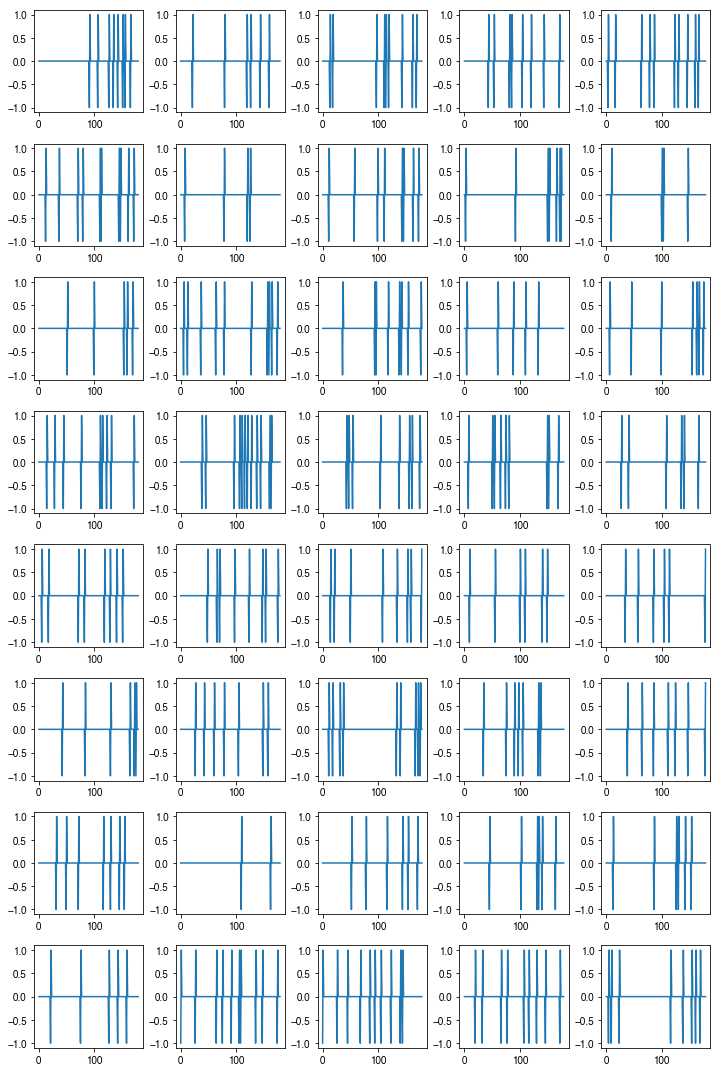

In [11]:
fig = mp.figure(figsize=(10,15))

for i in range(40):
    ax = fig.add_subplot(8,5,i+1)
    ax.plot(whiplash_hist_rcp_markers_reshape[:,i,9,17])
fig.tight_layout()

# Save as netcdf file

In [91]:
print(whiplash_hist_rcp_markers_reshape.shape)

(180, 40, 26, 25)


In [94]:
# ========= save netcdf files of -1,1 whiplash values for hist+RCP8.5
year_list = numpy.arange(1921,2101)
time_datetime = [datetime.datetime(i,1,15) for i in year_list]
time_nc = netCDF4.date2num(time_datetime, units='days since 1920-01-01', calendar='standard')





# save hist clim
filename = 'time_series_hist_rcp_dry20_wet80_events_with_whiplash.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

time_dim = ncfile.createDimension('time', None)
time_var = ncfile.createVariable('time', 'f4', ('time',))
time_var[:] = time_nc
time_var.units = 'days since 1920-01-01'

lat_dim = ncfile.createDimension('lat', PRECT_nlat)
lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lat_var[:] = PRECT_lat
lat_var.units = 'degrees North'

lon_dim = ncfile.createDimension('lon', PRECT_nlon)
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lon_var[:] = PRECT_lon
lon_var.units = 'degrees East'

ens_dim = ncfile.createDimension('ensemble', len(ensemble_names))
ens_var = ncfile.createVariable('ensemble', 'f4', ('ensemble',))
ens_var[:] = ensemble_names
ens_var.units = 'NCAR LENS ensemble member'

whiplash_ratios_var = ncfile.createVariable('whiplash_ratios_change', 'f4', ('time','ensemble','lat','lon',))
whiplash_ratios_var.units = 'whiplash ratios over time relative to PIC as a percent'
whiplash_ratios_var[:] = whiplash_ratios_change

all_dry_events_var = ncfile.createVariable('all_dry_events', 'f4', ('time','ensemble','lat','lon',))
all_dry_events_var.units = 'all dry events, not just whiplash (seasonal totals falling below 20th percentil PIC) are marked by a -1'
all_dry_events_var[:] = all_hist_rcp_dry

all_wet_events_var = ncfile.createVariable('all_wet_events', 'f4', ('time','ensemble','lat','lon',))
all_wet_events_var.units = 'all dry events, not just whiplash (seasonal totals falling below 20th percentil PIC) are marked by a +1'
all_wet_events_var[:] = all_hist_rcp_wet

ncfile.close()


file exists


In [82]:
print(whiplash_pic_markers_reshape.shape)

(1798, 26, 25)
